# Self-consistent implementation for automatic large-scale data collection

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import stats, signal, optimize
from tqdm import tqdm

import os, sys
rootpath = os.path.join(os.getcwd(), '.')
sys.path.append(rootpath)
from src.simulation import *
from src.approximation import *
# reimport modules if they change
%load_ext autoreload
%autoreload 2

## API

In [3]:
coupling_weights?

Signature: coupling_weights(N, K, lambda_, seed)
Docstring:
Generate coupling weights.

Parameters
----------
N : int
    Number of neurons.
K : int
    Avg. number of connections per neuron
lambda_ : float
    total incomming synaptic weight per neuron (lambda_ = sum_j w_ij)
seed : int
    Random seed.   

Returns
-------
w : sparse matrix of shape (N,N)
    Connectivity matrix.
File:      ~/git/projects/sahel_finite-observation-dynamic-range/src/simulation.py
Type:      function

In [4]:
print('quick test of API:')
N=20
K=5
lambda_=0.9
seed=1000

w = coupling_weights(N, K, lambda_, seed)
# lambda = sum_j w_ij
print(f"sum along axis 1 should always be lambda={lambda_}", np.sum(w, axis=1).flatten())
print(f"sum along axis 0 should be unique", np.sum(w, axis=0).flatten())

quick test of API:
sum along axis 1 should always be lambda=0.9 [[0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9 0.9
  0.9 0.9]]
sum along axis 0 should be unique [[0.32612079 1.30571757 0.45810899 0.92250997 0.52867078 1.05335852
  1.52587476 0.53218388 0.74912071 0.83269695 0.03453384 1.20628457
  1.74465463 0.73204387 0.97564305 1.45964052 0.63737817 0.43729386
  1.42263608 1.11552849]]


In [5]:
external_spiking_probability?

Signature: external_spiking_probability(N, mu, h_, seed, dt=1)
Docstring:
Generate external spiking probability vector.

Parameters
----------
N : int
    Number of neurons.
mu : float
    Fraction of neurons that receive external input
h_ : float
    External input rate that selected neurons receive
seed : int
    Random seed.
dt : float
    Time step.

Returns
-------
h : array of shape (2,mu*N)
    External spiking probability.
File:      ~/git/projects/sahel_finite-observation-dynamic-range/src/simulation.py
Type:      function

In [6]:
output_mask?

Signature: output_mask(N, nu, seed)
Docstring:
Generate output mask.

Parameters
----------
N : int
    Number of neurons.
nu : float
    Fraction of neurons that are connected to the output estimate
seed : int
    Random seed.

Returns
-------
mask_output : array of shape (N,)
    Mask that specifies from which neurons the output is recorded.
File:      ~/git/projects/sahel_finite-observation-dynamic-range/src/simulation.py
Type:      function

In [7]:
print('quick test of API:')
N=20
mu=0.2
h=2
seed=1000
p_h = external_spiking_probability(N, mu, h, seed)
# with mu=0.2 there should be 20/5=4 neurons spiking on average
print(f"neurons with external input (should be N*mu={N*mu}): ", p_h[0])
print(f"spiking probability (should be 1-exp(-h*dt)={1-np.exp(-h)}): ", p_h[1])

quick test of API:
neurons with external input (should be N*mu=4.0):  [ 5 18  3  6]
spiking probability (should be 1-exp(-h*dt)=0.8646647167633873):  [0.86466472 0.86466472 0.86466472 0.86466472]


## Verify with analytic calculation of mean activity

In [11]:
N=int(1e4)
K=100
list_h=np.logspace(-5,1,6)
mu=0.2
dt=1
# prepare for reset in loop
p_h = external_spiking_probability(N, mu, 0, seed=1234, dt=1)
# recurrent coupling fixed
lambda_ = 0.9
w = coupling_weights(N, K, lambda_, seed=1234)

# run self-build simulations
T = 1000
T_burn = 100
list_a = np.zeros_like(list_h)
rng = np.random.default_rng(1234)
for (i,h) in tqdm(enumerate(list_h), total=len(list_h)):
    p_h = external_spiking_probability(N, mu, h, seed=1234, dt=1)
    activity = np.zeros(T)
    x = np.zeros(N)
    for t in range(T):
        x = step(x, w, p_h, rng)
        activity[t] = np.mean(x)
    list_a[i] = np.mean(activity[T_burn:])

100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


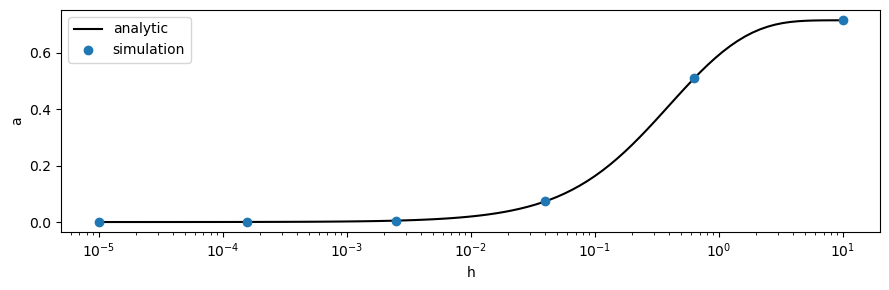

In [12]:
def a(h, mu, lambda_, dt=1):
    return mu*(1-np.exp(-h*dt))/(1-lambda_*(1-mu)-lambda_*mu*np.exp(-h*dt))

list_h_ana = np.logspace(-5,1,100)
list_a_ana = [a(h, mu, lambda_) for h in list_h_ana]

plt.figure(figsize=(9,3))
plt.plot(list_h_ana, list_a_ana, '-', label='analytic', color='black')
plt.plot(list_h, list_a, 'o', label='simulation')
plt.xscale('log')
plt.xlabel('h')
plt.ylabel('a')
plt.legend()
plt.tight_layout()

## Prepare automatic simulations
For simplicity, the window here is implemented as an exponential moving average such that $o_T = 1/T \sum_t o_t$ is replaced by $o_T = \sum_t' o_t' e^{(t-t')/T}$

In [13]:
simulation?

Signature:
simulation(
    params,
    steps={'burn': 'self', 'equil': 'self', 'record': 'self'},
    windows=array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
)
Docstring:
run simulation and return sliding window estimates

Parameters
----------
params : dict
    dictionary with parameters that needs to include
    - N : int
        number of neurons
    - K : int
        number of incoming connections per neuron
    - lambda : float
        coupling strength
    - mu : float
        fraction of neurons that receive external input
    - nu : float
        fraction of neurons that are connected to the output estimate
    - h : float
        external input
    - seed_s : int
        random seed static setup (recurrent weights and external coupling)
    - seed_d : int
        random seed for dynamics
steps : dict
    dictionary with update steps for different phases of the simulation (default is self-consistently determined with autorcorelation time tau(lambda) and processing window )
   

Example for small input and large fluctuations

In [15]:
params = {
    'N': int(1e4),
    'K': 100,
    'lambda': 0.9,
    'mu': 0.2,
    'nu': 0.2,
    'h': 1e-5,
    'seed_s': 1000,
    'seed_d': 1000,
}
example1 = simulation(params, windows=np.array([1.0,10.0,100.0]))

# COMMENT: burn-in steps self-consistently set to 2.84e+02 = max(30 * tau, window_max) with tau = -dt / ln(lambda) = 9.49e+00 and window_max=1.00e+02
# COMMENT: equilibration steps self-consistently set to 3.00e+02 = 3 * window_max = 1.00e+02
# COMMENT: recording steps self-consistently set to 1.00e+04 = max(1000 * tau, 100*window_max) with tau = -dt / ln(lambda) = 9.49e+00 and window_max=1.00e+02
initialize with random spiking condition


recording: 100%|██████████| 10000/10000 [00:14<00:00, 686.98it/s]


1.0	4.08e+00,3.23e+04,-0.0001,1.0002, 0.0001261314630732693, 2.592234764055756e-05
10.0	7.88e+00,6.25e+04,-0.0001,1.0002, 0.00012605775960568646, 2.585180646926148e-05
100.0	2.30e+01,1.81e+05,-0.0001,1.0002, 0.00012709777176581584, 2.6892774194503366e-05


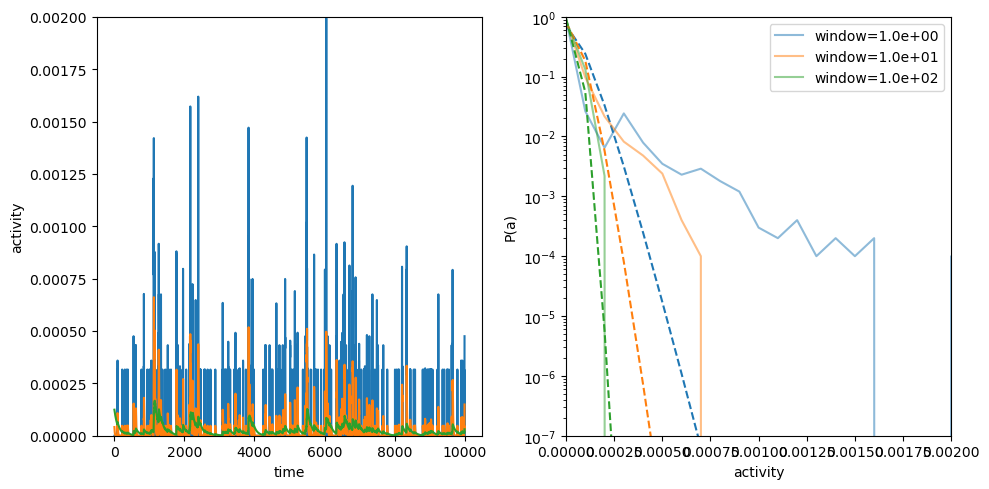

In [16]:
result = example1
windows = result['windows']

# plot distribution of estimates for different windows in one plot
fig, axes = plt.subplots(1,2, figsize=(10,5))
# plot samples over time
axes[0].set_xlabel('time')
axes[0].set_ylabel('activity')

# plot distribution of estimates for different windows in one plot
range_data = [1,0]
for (i,window) in enumerate(windows):
    data = result[f'samples'][window]
    axes[0].plot(data)
    # spacing should depend on window size, larger windows means smaller discretization (but then this also requires more samples ...)
    delta = 1/params['N']
    support = np.linspace(0,1,params['N']+1)
    pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
    ref = axes[1].plot(support, pmf_data, label=f'window={windows[i]:.1e}', alpha=0.5)
    # fit beta distribution
    a,b,loc,scale = fit_beta_distribution(data, delta, 1234)
    print(f'{window}\t{a:.2e},{b:.2e},{loc},{scale}, {a/(a+b)}, {np.mean(data)}')
    pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
    pmf_beta = pmf_beta/np.sum(pmf_beta)
    axes[1].plot(support,pmf_beta, color=ref[0].get_color(), linestyle='--')

    range_data[0] = min(range_data[0], support[np.nonzero(pmf_data)][0])
    range_data[1] = max(range_data[1], support[np.nonzero(pmf_data)][-1])
axes[1].set_xlabel('activity')
axes[1].set_ylabel('P(a)')
# set xrange to range of data
axes[1].set_yscale('log')
axes[1].set_ylim([1e-7,1])
axes[1].set_xlim(range_data)
axes[0].set_ylim(range_data)
axes[1].legend()
plt.tight_layout()

Example for medium input and small fluctuations

In [11]:
params = {
    'N': int(1e4),
    'K': 100,
    'lambda': 0.9,
    'mu': 0.2,
    'nu': 0.2,
    'h': 1e-3,
    'seed_s': 1000,
    'seed_d': 1000,
    'dt': 1,
}
example2 = simulation(params, windows=np.array([1e0, 1e1, 1e2]))

# COMMENT: burn-in steps self-consistently set to 2.84e+02 = max(30 * tau, window_max) with tau = -dt / ln(lambda) = 9.49e+00 and window_max=1.00e+02
# COMMENT: equilibration steps self-consistently set to 3.00e+02 = 3 * window_max = 1.00e+02
# COMMENT: recording steps self-consistently set to 1.00e+04 = max(1000 * tau, 100*window_max) with tau = -dt / ln(lambda) = 9.49e+00 and window_max=1.00e+02
initialize with random spiking condition


recording: 100%|██████████| 10000/10000 [00:10<00:00, 929.90it/s]


1.0	4.16e+00,1.89e+03,-0.0001,1.0002, 0.002198315458519809, 0.00209891666856178
10.0	7.87e+00,3.57e+03,-0.0001,1.0002, 0.002198157017262753, 0.002098753713463768
100.0	4.08e+01,1.85e+04,-0.0001,1.0002, 0.002198541674107835, 0.002099151259892404


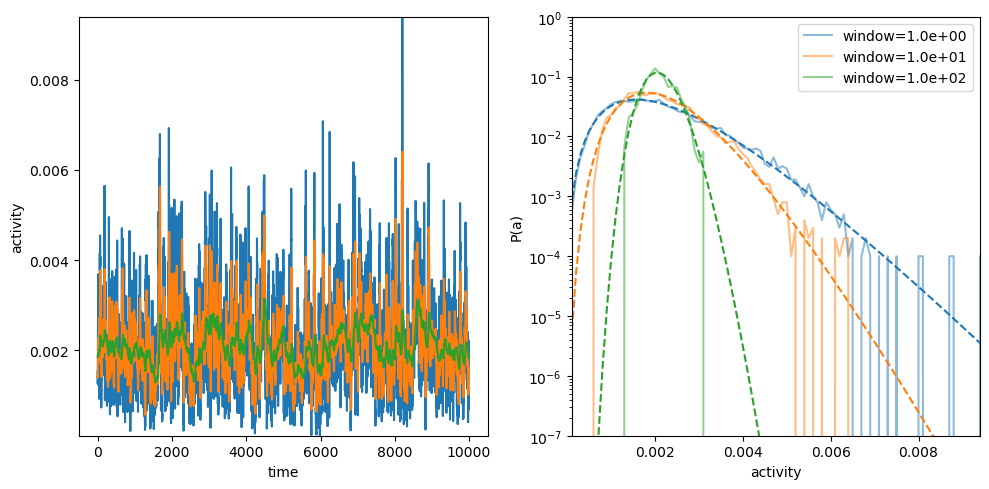

In [12]:
result = example2
windows = result['windows']

# plot distribution of estimates for different windows in one plot
fig, axes = plt.subplots(1,2, figsize=(10,5))
# plot samples over time
axes[0].set_xlabel('time')
axes[0].set_ylabel('activity')

# plot distribution of estimates for different windows in one plot
range_data = [1,0]
for (i,window) in enumerate(windows):
    data = result['samples'][window]
    #timeseries
    axes[0].plot(data)
    # distributions
    delta = 1/N
    support = np.linspace(0,1,N+1)
    pmf_data = np.histogram(data, bins=np.append(support,1+delta)-delta/2, density=False)[0]/len(data)
    ref = axes[1].plot(support, pmf_data, label=f'window={windows[i]:.1e}', alpha=0.5)
    # fit beta distribution
    a,b,loc,scale = fit_beta_distribution(data, delta, seed)
    print(f'{window}\t{a:.2e},{b:.2e},{loc},{scale}, {a/(a+b)}, {np.mean(data)}')
    pmf_beta = stats.beta.pdf(support, a,b, loc=loc, scale=scale)
    pmf_beta = pmf_beta/np.sum(pmf_beta)
    axes[1].plot(support,pmf_beta, color=ref[0].get_color(), linestyle='--')

    range_data[0] = min(range_data[0], support[np.nonzero(pmf_data)][0])
    range_data[1] = max(range_data[1], support[np.nonzero(pmf_data)][-1])
axes[1].set_xlabel('activity')
axes[1].set_ylabel('P(a)')
# set xrange to range of data
axes[1].set_yscale('log')
axes[1].set_ylim([1e-7,1])
axes[1].set_xlim(range_data)
axes[0].set_ylim(range_data)
axes[1].legend()
plt.tight_layout()
